In [1]:
import os
import numpy as np
import random
import tensorflow as tf

seed = 1729959202

np.random.seed(seed)

random.seed(seed)

tf.random.set_seed(seed)

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

2024-11-23 15:50:59.112649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732373459.235946  134480 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732373459.267746  134480 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 15:50:59.569773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


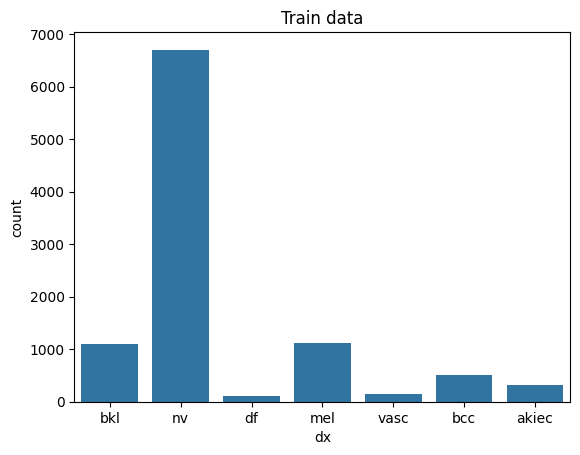

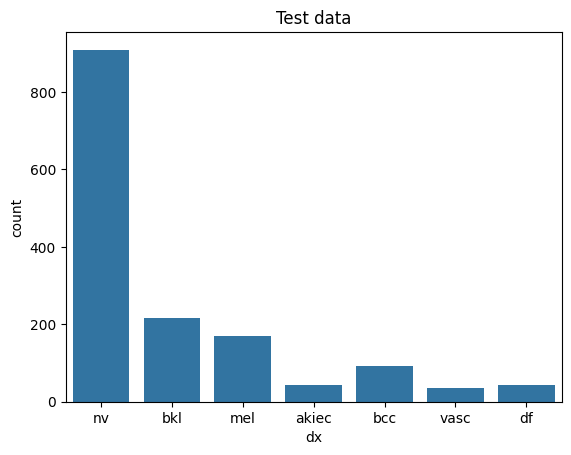

In [2]:
data_path = 'data/ham10000/HAM10000_metadata.csv'
df = pd.read_csv(data_path)

image_dir = 'data/ham10000/images/'  
test_image_dir = 'data/ham10000/images/test_images/'

df['image_path'] = image_dir + df['image_id'] + '.jpg'

df.head()

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])

sns.countplot(x='dx', data=df)
plt.title('Train data')
plt.show()

test_data_path = 'data/ham10000/images/ISIC2018_Task3_Test_GroundTruth.csv'

test_df = pd.read_csv(test_data_path)
test_df['image_path'] = test_image_dir + test_df['image_id'] + '.jpg'
test_df['label'] = label_encoder.transform(test_df['dx'])

sns.countplot(x='dx', data=test_df)
plt.title('Test data')
plt.show()

train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

In [3]:
# Extract only the image name and extension for each set
train_set = set(os.path.basename(path) for path in train_df['image_path'])
val_set = set(os.path.basename(path) for path in val_df['image_path'])
test_set = set(os.path.basename(path) for path in test_df['image_path'])

# print the path of the first image in the training set and the test set
print("First image in the training set:", list(train_set)[0])
print("First image in the test set:", list(test_set)[0])



print("Overlaps between train and validation:", len(train_set.intersection(val_set)))
print("Overlaps between train and test:", len(train_set.intersection(test_set)))
print("Overlaps between validation and test:", len(val_set.intersection(test_set)))

First image in the training set: ISIC_0031272.jpg
First image in the test set: ISIC_0034707.jpg
Overlaps between train and validation: 0
Overlaps between train and test: 0
Overlaps between validation and test: 0


In [4]:
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [5]:
image_size = (128, 128)
batch_size = 64
num_classes = len(df['dx'].unique())
img_height, img_width = image_size

def load_and_preprocess_image(image_path, label, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0  

    if augment:
        img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))  
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, max_delta=0.2)

    return img, label

def create_dataset(df, augment=False, batch_size=32):
    df = df[df['image_path'].apply(os.path.exists)]
    
    image_paths = df['image_path'].values
    labels = df['label'].values
    labels = tf.keras.utils.to_categorical(labels, num_classes)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def preprocess_with_augment(image_path, label):
        return load_and_preprocess_image(image_path, label, augment)

    dataset = dataset.map(preprocess_with_augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

train_dataset = create_dataset(train_df, augment=True, batch_size=batch_size)
val_dataset = create_dataset(val_df, batch_size=batch_size)
# test_dataset = create_dataset(test_df, batch_size=batch_size)


I0000 00:00:1732373463.842763  134480 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:09:00.0, compute capability: 8.6


In [6]:
import optuna
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [7]:
def build_model(trial):
    conv_1_filters = trial.suggest_int('conv_1_filters', 32, 256, step=32)
    conv_2_filters = trial.suggest_int('conv_2_filters', 32, 128, step=32)
    conv_3_filters = trial.suggest_int('conv_3_filters', 32, 64, step=16)
    dense_units = trial.suggest_int('dense_units', 64, 256, step=64)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])


    model = Sequential()
    input_shape = (128, 128, 3)
    model.add(Input(input_shape))
    
    model.add(Conv2D(
        filters=conv_1_filters,
        kernel_size=(2, 2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=conv_2_filters,
        kernel_size=(2, 2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=conv_3_filters,
        kernel_size=(2, 2),
        activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=dense_units, activation=activation))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model



In [8]:
def objective(trial):
    model = build_model(trial)
    

    # Fit the model
    history = model.fit(
        train_dataset,
        epochs=20,
        validation_data=val_dataset,
        verbose=1)

    # Return the validation accuracy
    return history.history['val_accuracy'][-1]

In [9]:
# Set up and optimize the Optuna study
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(), study_name='random_search_optuna_float16', storage='sqlite:///optuna/db.sqlite3', load_if_exists=True)  # We are maximizing validation accuracy
study.optimize(objective, n_trials=50)

# Print the best hyperparameters found
print('Best hyperparameters:', study.best_params)

[I 2024-11-23 15:51:04,514] Using an existing study with name 'random_search_optuna_float16' instead of creating a new one.


Epoch 1/20


I0000 00:00:1732373466.461480  134611 service.cc:148] XLA service 0x7f7a6800cbf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732373466.469696  134611 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-11-23 15:51:06.662913: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732373466.826785  134611 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/141 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3697 - loss: 3.5678

I0000 00:00:1732373471.070613  134611 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.6287 - loss: 2.3520 - val_accuracy: 0.6697 - val_loss: 0.9848
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6686 - loss: 1.0372 - val_accuracy: 0.6697 - val_loss: 0.9496
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6718 - loss: 0.9856 - val_accuracy: 0.6697 - val_loss: 0.9346
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6711 - loss: 0.9809 - val_accuracy: 0.6697 - val_loss: 0.9724
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6705 - loss: 1.0033 - val_accuracy: 0.6697 - val_loss: 0.9291
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6702 - loss: 0.9480 - val_accuracy: 0.6697 - val_loss: 0.9355
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6689 - loss: 0.9644 - val_accuracy: 0.6697 - val_loss: 0.9518
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6701 - loss: 0.9431 - val_accuracy: 0.66

[I 2024-11-23 15:52:31,487] Trial 42 finished with value: 0.6846307516098022 and parameters: {'conv_1_filters': 96, 'conv_2_filters': 96, 'conv_3_filters': 32, 'dense_units': 64, 'learning_rate': 0.007557632159436858, 'activation': 'relu'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6469 - loss: 1.2964

2024-11-23 15:52:47.003874: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 500 bytes spill stores, 596 bytes spill loads

2024-11-23 15:52:47.047696: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 724 bytes spill stores, 820 bytes spill loads

2024-11-23 15:52:49.157423: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 12 bytes spill stores, 12 bytes spill loads

2024-11-23 15:52:49.513723: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 912 bytes spill stores, 788 bytes spill loads

2024-11-23 15:52:49.556003: I external/local_xla/xla/stream_e

141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.6470 - loss: 1.2956 - val_accuracy: 0.6657 - val_loss: 0.9662
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6703 - loss: 0.9727 - val_accuracy: 0.6687 - val_loss: 0.9245
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6729 - loss: 0.9464 - val_accuracy: 0.6697 - val_loss: 0.9416
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6734 - loss: 0.9153 - val_accuracy: 0.6707 - val_loss: 0.8970
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6747 - loss: 0.8899 - val_accuracy: 0.6717 - val_loss: 0.9288
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6829 - loss: 0.8895 - val_accuracy: 0.6876 - val_loss: 0.8906
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6847 - loss: 0.8601 - val_accuracy: 0.7006 - val_loss: 0.8925
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6906 - loss: 0.8475 - val_accuracy: 0.69

[I 2024-11-23 15:54:03,788] Trial 43 finished with value: 0.71856290102005 and parameters: {'conv_1_filters': 160, 'conv_2_filters': 128, 'conv_3_filters': 32, 'dense_units': 192, 'learning_rate': 0.00208350378398454, 'activation': 'relu'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6294 - loss: 1.7755

2024-11-23 15:54:16.061204: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_97', 12 bytes spill stores, 12 bytes spill loads



141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.6295 - loss: 1.7733 - val_accuracy: 0.6697 - val_loss: 1.1417
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6713 - loss: 1.1903 - val_accuracy: 0.6697 - val_loss: 1.1387
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6719 - loss: 1.1583 - val_accuracy: 0.6697 - val_loss: 1.1382
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6716 - loss: 1.1561 - val_accuracy: 0.6697 - val_loss: 1.1393
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6715 - loss: 1.1582 - val_accuracy: 0.6697 - val_loss: 1.1401
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6715 - loss: 1.1547 - val_accuracy: 0.6697 - val_loss: 1.1387
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6717 - loss: 1.1500 - val_accuracy: 0.6697 - val_loss: 1.1379
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6717 - loss: 1.1551 - val_accuracy: 0.66

[I 2024-11-23 15:55:28,389] Trial 44 finished with value: 0.6696606874465942 and parameters: {'conv_1_filters': 128, 'conv_2_filters': 96, 'conv_3_filters': 32, 'dense_units': 192, 'learning_rate': 0.00345772052597801, 'activation': 'sigmoid'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6538 - loss: 5.1754

2024-11-23 15:55:45.305891: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 652 bytes spill stores, 732 bytes spill loads

2024-11-23 15:55:47.230557: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 824 bytes spill stores, 708 bytes spill loads



141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - accuracy: 0.6538 - loss: 5.1761 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6714 - loss: 5.2957 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6716 - loss: 5.2931 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6721 - loss: 5.2858 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6718 - loss: 5.2893 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6721 - loss: 5.2845 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6718 - loss: 5.2898 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6716 - loss: 5.2928 - val_accuracy: 0.66

[I 2024-11-23 15:57:13,073] Trial 45 finished with value: 0.6696606874465942 and parameters: {'conv_1_filters': 256, 'conv_2_filters': 96, 'conv_3_filters': 48, 'dense_units': 128, 'learning_rate': 0.008089466733168087, 'activation': 'relu'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5988 - loss: 2.3869

2024-11-23 15:57:27.737809: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 12 bytes spill stores, 12 bytes spill loads

2024-11-23 15:57:27.805471: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 376 bytes spill stores, 440 bytes spill loads

2024-11-23 15:57:27.980779: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 580 bytes spill stores, 644 bytes spill loads

2024-11-23 15:57:28.790477: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 4 bytes spill stores, 4 bytes spill loads

2024-11-23 15:57:28.930342: I external/local_xla/xla/stream_execut

141/141 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.5989 - loss: 2.3831 - val_accuracy: 0.6617 - val_loss: 0.9806
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6689 - loss: 0.9689 - val_accuracy: 0.6806 - val_loss: 0.9139
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6837 - loss: 0.9140 - val_accuracy: 0.7006 - val_loss: 0.8688
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.6927 - loss: 0.8700 - val_accuracy: 0.7086 - val_loss: 0.8495
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7004 - loss: 0.8391 - val_accuracy: 0.7086 - val_loss: 0.8343
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7148 - loss: 0.8083 - val_accuracy: 0.7116 - val_loss: 0.8180
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7280 - loss: 0.7876 - val_accuracy: 0.7196 - val_loss: 0.8052
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7293 - loss: 0.7689 - val_accuracy: 0.71

[I 2024-11-23 15:58:44,046] Trial 46 finished with value: 0.7115768194198608 and parameters: {'conv_1_filters': 192, 'conv_2_filters': 64, 'conv_3_filters': 64, 'dense_units': 192, 'learning_rate': 0.0005765921709073043, 'activation': 'tanh'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.6285 - loss: 1.2725 - val_accuracy: 0.6687 - val_loss: 0.9699
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6649 - loss: 0.9978 - val_accuracy: 0.6876 - val_loss: 0.9135
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6727 - loss: 0.9246 - val_accuracy: 0.6816 - val_loss: 0.8786
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6852 - loss: 0.8950 - val_accuracy: 0.7076 - val_loss: 0.8515
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6945 - loss: 0.8612 - val_accuracy: 0.6986 - val_loss: 0.8649
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7046 - loss: 0.8349 - val_accuracy: 0.7226 - val_loss: 0.8222
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.7177 - loss: 0.8075 - val_accuracy: 0.7186 - val_loss: 0.8047
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.7196 - loss: 0.7912 - val_acc

[I 2024-11-23 16:00:31,514] Trial 47 finished with value: 0.7165668606758118 and parameters: {'conv_1_filters': 256, 'conv_2_filters': 128, 'conv_3_filters': 48, 'dense_units': 64, 'learning_rate': 0.00036596807019905305, 'activation': 'tanh'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6483 - loss: 1.1834

2024-11-23 16:00:41.769581: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 724 bytes spill stores, 820 bytes spill loads

2024-11-23 16:00:42.922224: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 936 bytes spill stores, 804 bytes spill loads



141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.6484 - loss: 1.1829 - val_accuracy: 0.6697 - val_loss: 0.9639
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6721 - loss: 0.9748 - val_accuracy: 0.6707 - val_loss: 0.9235
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6737 - loss: 0.9278 - val_accuracy: 0.6756 - val_loss: 0.9115
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6723 - loss: 0.8924 - val_accuracy: 0.6796 - val_loss: 0.8857
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6833 - loss: 0.8798 - val_accuracy: 0.6846 - val_loss: 0.8747
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6885 - loss: 0.8678 - val_accuracy: 0.6836 - val_loss: 0.8528
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6851 - loss: 0.8442 - val_accuracy: 0.6816 - val_loss: 0.8346
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6988 - loss: 0.8195 - val_accuracy: 0.69

[I 2024-11-23 16:01:53,875] Trial 48 finished with value: 0.7355289459228516 and parameters: {'conv_1_filters': 160, 'conv_2_filters': 32, 'conv_3_filters': 32, 'dense_units': 128, 'learning_rate': 0.00049249832676828, 'activation': 'relu'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6481 - loss: 1.2931 - val_accuracy: 0.6707 - val_loss: 0.9839
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6691 - loss: 0.9743 - val_accuracy: 0.6766 - val_loss: 0.9051
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6854 - loss: 0.9130 - val_accuracy: 0.6866 - val_loss: 0.9022
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6908 - loss: 0.8831 - val_accuracy: 0.7116 - val_loss: 0.8705
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7034 - loss: 0.8494 - val_accuracy: 0.7116 - val_loss: 0.8521
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7087 - loss: 0.8296 - val_accuracy: 0.7136 - val_loss: 0.8303
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7116 - loss: 0.8184 - val_accuracy: 0.7176 - val_loss: 0.8429
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7148 - loss: 0.8092 - val_accu

[I 2024-11-23 16:03:11,915] Trial 49 finished with value: 0.7265468835830688 and parameters: {'conv_1_filters': 32, 'conv_2_filters': 128, 'conv_3_filters': 48, 'dense_units': 64, 'learning_rate': 0.0003447453548664183, 'activation': 'tanh'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.6409 - loss: 1.2915 - val_accuracy: 0.6697 - val_loss: 1.1402
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6710 - loss: 1.1782 - val_accuracy: 0.6697 - val_loss: 1.1335
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6717 - loss: 1.1735 - val_accuracy: 0.6697 - val_loss: 1.1349
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6717 - loss: 1.1667 - val_accuracy: 0.6697 - val_loss: 1.1348
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6723 - loss: 1.1608 - val_accuracy: 0.6697 - val_loss: 1.1333
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6715 - loss: 1.1556 - val_accuracy: 0.6697 - val_loss: 1.1319
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6712 - loss: 1.1592 - val_accuracy: 0.6697 - val_loss: 1.1328
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6717 - loss: 1.1614 - val_acc

[I 2024-11-23 16:04:35,682] Trial 50 finished with value: 0.6686626672744751 and parameters: {'conv_1_filters': 160, 'conv_2_filters': 64, 'conv_3_filters': 32, 'dense_units': 128, 'learning_rate': 0.00023770148987818152, 'activation': 'sigmoid'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.6378 - loss: 1.7964 - val_accuracy: 0.6697 - val_loss: 1.1349
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6708 - loss: 1.1968 - val_accuracy: 0.6697 - val_loss: 1.1394
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6717 - loss: 1.1694 - val_accuracy: 0.6697 - val_loss: 1.1350
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6716 - loss: 1.1647 - val_accuracy: 0.6697 - val_loss: 1.1358
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6716 - loss: 1.1559 - val_accuracy: 0.6697 - val_loss: 1.1337
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6714 - loss: 1.1529 - val_accuracy: 0.6697 - val_loss: 1.1337
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6715 - loss: 1.1499 - val_accuracy: 0.6697 - val_loss: 1.1326
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6714 - loss: 1.1516 - val_accu

[I 2024-11-23 16:05:54,168] Trial 51 finished with value: 0.6946107745170593 and parameters: {'conv_1_filters': 128, 'conv_2_filters': 64, 'conv_3_filters': 32, 'dense_units': 128, 'learning_rate': 0.0008669514715182277, 'activation': 'sigmoid'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6241 - loss: 2.2638

2024-11-23 16:06:04.463971: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 724 bytes spill stores, 820 bytes spill loads

2024-11-23 16:06:04.722157: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 504 bytes spill stores, 600 bytes spill loads

2024-11-23 16:06:05.669324: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_97', 4 bytes spill stores, 4 bytes spill loads

2024-11-23 16:06:06.144913: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 500 bytes spill stores, 596 bytes spill loads

2024-11-23 16:06:06.185599: I external/local_xla/xla/stream_exec

141/141 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - accuracy: 0.6242 - loss: 2.2594 - val_accuracy: 0.6697 - val_loss: 1.1445
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6681 - loss: 1.2106 - val_accuracy: 0.6697 - val_loss: 1.1399
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6713 - loss: 1.1768 - val_accuracy: 0.6697 - val_loss: 1.1393
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6713 - loss: 1.1612 - val_accuracy: 0.6697 - val_loss: 1.1389
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6713 - loss: 1.1582 - val_accuracy: 0.6697 - val_loss: 1.1388
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6713 - loss: 1.1478 - val_accuracy: 0.6697 - val_loss: 1.1391
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6713 - loss: 1.1524 - val_accuracy: 0.6697 - val_loss: 1.1389
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6713 - loss: 1.1560 - val_accuracy: 0.66

[I 2024-11-23 16:07:15,840] Trial 52 finished with value: 0.6696606874465942 and parameters: {'conv_1_filters': 96, 'conv_2_filters': 32, 'conv_3_filters': 32, 'dense_units': 256, 'learning_rate': 0.0028745233241680088, 'activation': 'sigmoid'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.4606 - loss: 4.1838 - val_accuracy: 0.6697 - val_loss: 1.1876
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6032 - loss: 1.4232 - val_accuracy: 0.6697 - val_loss: 1.1621
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6281 - loss: 1.3498 - val_accuracy: 0.6697 - val_loss: 1.1441
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6544 - loss: 1.2518 - val_accuracy: 0.6697 - val_loss: 1.1396
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6688 - loss: 1.2293 - val_accuracy: 0.6697 - val_loss: 1.1395
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6706 - loss: 1.1993 - val_accuracy: 0.6697 - val_loss: 1.1391
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6712 - loss: 1.1834 - val_accuracy: 0.6697 - val_loss: 1.1376
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6721 - loss: 1.1621 - val_acc

[I 2024-11-23 16:08:49,572] Trial 53 finished with value: 0.6696606874465942 and parameters: {'conv_1_filters': 256, 'conv_2_filters': 64, 'conv_3_filters': 48, 'dense_units': 128, 'learning_rate': 0.0010614838050478225, 'activation': 'tanh'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6476 - loss: 5.1608

2024-11-23 16:08:59.193373: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 652 bytes spill stores, 732 bytes spill loads

2024-11-23 16:08:59.455796: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 444 bytes spill stores, 524 bytes spill loads

2024-11-23 16:09:01.121337: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 412 bytes spill stores, 492 bytes spill loads

2024-11-23 16:09:01.303352: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 824 bytes spill stores, 708 bytes spill loads



141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.6477 - loss: 5.1616 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6720 - loss: 5.2872 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6713 - loss: 5.2978 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6707 - loss: 5.3078 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6715 - loss: 5.2949 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6711 - loss: 5.3014 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6713 - loss: 5.2982 - val_accuracy: 0.6697 - val_loss: 5.3244
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6714 - loss: 5.2962 - val_accuracy: 0.66

[I 2024-11-23 16:10:11,614] Trial 54 finished with value: 0.6696606874465942 and parameters: {'conv_1_filters': 128, 'conv_2_filters': 128, 'conv_3_filters': 48, 'dense_units': 256, 'learning_rate': 0.005728313742401434, 'activation': 'relu'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6230 - loss: 2.2389 - val_accuracy: 0.6697 - val_loss: 1.1562
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6717 - loss: 1.2004 - val_accuracy: 0.6697 - val_loss: 1.1558
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6707 - loss: 1.1874 - val_accuracy: 0.6697 - val_loss: 1.1524
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6716 - loss: 1.1843 - val_accuracy: 0.6697 - val_loss: 1.1522
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6711 - loss: 1.1771 - val_accuracy: 0.6697 - val_loss: 1.1497
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6708 - loss: 1.1859 - val_accuracy: 0.6697 - val_loss: 1.1481
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6714 - loss: 1.1800 - val_accuracy: 0.6697 - val_loss: 1.1478
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6717 - loss: 1.1784 - val_accu

[I 2024-11-23 16:11:30,381] Trial 55 finished with value: 0.6696606874465942 and parameters: {'conv_1_filters': 128, 'conv_2_filters': 128, 'conv_3_filters': 48, 'dense_units': 256, 'learning_rate': 0.00542587351905624, 'activation': 'sigmoid'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.3610 - loss: 7.5991 - val_accuracy: 0.6697 - val_loss: 1.1878
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6222 - loss: 1.3875 - val_accuracy: 0.6697 - val_loss: 1.1558
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6370 - loss: 1.3298 - val_accuracy: 0.6697 - val_loss: 1.1443
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6513 - loss: 1.2880 - val_accuracy: 0.6697 - val_loss: 1.1392
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.6589 - loss: 1.2384 - val_accuracy: 0.6697 - val_loss: 1.1368
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6693 - loss: 1.2165 - val_accuracy: 0.6697 - val_loss: 1.1381
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6707 - loss: 1.2028 - val_accuracy: 0.6697 - val_loss: 1.1396
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6712 - loss: 1.1888 - val_accu

[I 2024-11-23 16:12:59,410] Trial 56 finished with value: 0.6696606874465942 and parameters: {'conv_1_filters': 256, 'conv_2_filters': 64, 'conv_3_filters': 64, 'dense_units': 192, 'learning_rate': 0.0007938831226748433, 'activation': 'tanh'}. Best is trial 11 with value: 0.7385229468345642.


Epoch 1/20
 85/141 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4071 - loss: 5.4055

[W 2024-11-23 16:13:09,151] Trial 57 failed with parameters: {'conv_1_filters': 224, 'conv_2_filters': 96, 'conv_3_filters': 64, 'dense_units': 192, 'learning_rate': 0.004292349176236798, 'activation': 'tanh'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/bosa/manu/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_134480/3879541452.py", line 6, in objective
    history = model.fit(
  File "/home/bosa/manu/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/home/bosa/manu/venv/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
    logs = self.train_function(iterator)
  File "/home/bosa/manu/venv/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwa

KeyboardInterrupt: 

In [10]:
study.best_params

{'conv_1_filters': 256,
 'conv_2_filters': 64,
 'conv_3_filters': 48,
 'dense_units': 128,
 'learning_rate': 0.00010724940403461976,
 'activation': 'tanh'}

In [11]:
best_model = Sequential()
input_shape = (128, 128, 3)
best_model.add(Input(input_shape))

best_model.add(Conv2D(
    filters=study.best_params['conv_1_filters'],
    kernel_size=(2, 2),
    activation=study.best_params['activation']))

best_model.add(MaxPooling2D(pool_size=(2, 2)))

best_model.add(Conv2D(
    filters=study.best_params['conv_2_filters'],
    kernel_size=(2, 2),
    activation=study.best_params['activation']))

best_model.add(MaxPooling2D(pool_size=(2, 2)))

best_model.add(Conv2D(
    filters=study.best_params['conv_3_filters'],
    kernel_size=(2, 2),
    activation=study.best_params['activation']))

best_model.add(MaxPooling2D(pool_size=(2, 2)))

best_model.add(Flatten())

best_model.add(Dense(units=study.best_params['dense_units'], activation=study.best_params['activation']))

best_model.add(Dropout(0.5))

best_model.add(Dense(7, activation='softmax'))

best_model.compile(
    optimizer=tf.keras.optimizers.Adam(study.best_params['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

history = best_model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    verbose=1)

# evaluate best model

test_dataset = create_dataset(test_df, batch_size=batch_size)




Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.6471 - loss: 1.1612 - val_accuracy: 0.6687 - val_loss: 0.9932
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6674 - loss: 0.9887 - val_accuracy: 0.6747 - val_loss: 0.9554
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6766 - loss: 0.9374 - val_accuracy: 0.6786 - val_loss: 0.9165
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6816 - loss: 0.8994 - val_accuracy: 0.6896 - val_loss: 0.8903
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6892 - loss: 0.8675 - val_accuracy: 0.6946 - val_loss: 0.8775
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.6998 - loss: 0.8563 - val_accuracy: 0.6876 - val_loss: 0.8632
Epoch 7/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7016 - loss: 0.8332 - val_accuracy: 0.6986 - val_loss: 0.8601
Epoch 8/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7080 - loss: 0.8229 - val_accu

22/24 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7011 - loss: 0.8255

2024-11-23 16:14:51.738623: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 824 bytes spill stores, 708 bytes spill loads



24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 0.6978 - loss: 0.8373
Test Accuracy: 0.6730641722679138


2024-11-23 16:14:53.068908: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Best model OVO AUC: 0.8708519494994027
Best model OVR AUC: 0.8708519494994027
Best model F1 Score: 0.6295255781924594


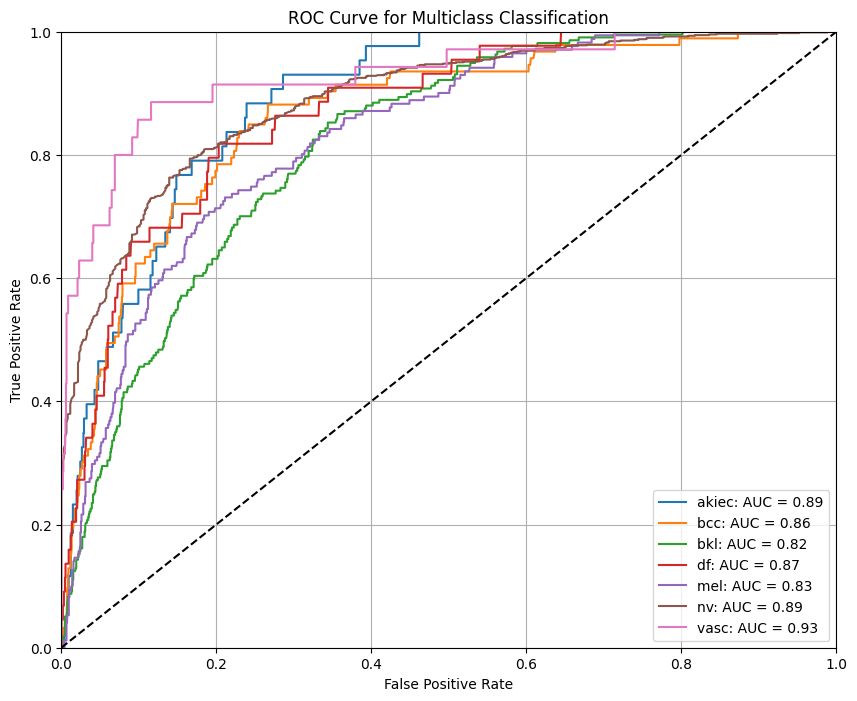

In [12]:
# Evaluate the best model on the test dataset
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f'Test Accuracy: {test_acc}')

# Calculate AUC and F1 scores
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_score = best_model.predict(test_dataset)

baseline_ovo_auc = roc_auc_score(y_true, y_score, multi_class="ovo")
baseline_ovr_auc = roc_auc_score(y_true, y_score, multi_class="ovr")
baseline_f1_score = f1_score(y_true.argmax(axis=1), y_score.argmax(axis=1), average="weighted")

print(f'Best model OVO AUC: {baseline_ovo_auc}')
print(f'Best model OVR AUC: {baseline_ovr_auc}')
print(f'Best model F1 Score: {baseline_f1_score}')

# Plot ROC curves
y_true = to_categorical(np.argmax(y_true, axis=1), num_classes)
class_names = label_encoder.inverse_transform(np.arange(num_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]}: AUC = {roc_auc[i]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()